In [35]:
# ! pip install sturdy-stats-sdk pandas numpy plotly seaborn

In [ ]:
from sturdystats import Index, Job
import pandas as pd
import numpy as np

API_KEY = None

# 1. Load a Dataset of Earnings Calls

Earnings calls are large conference calls held by public companies following the publication of each earnings report.
Earnings calls give investors and analysts an opportunity to ask the company for clarification about its financial performance.
These calls, which are all publicly available, are a great source of information about companies: both what the companies highlight as major factors influencing their performance, and about what investors and analysts are most interested in learning about each company.

For this demo, we have prepared a dataset containing earnings calls for the companies _Google_, _Apple_, _Meta_, _Microsoft_, and _Nvidia_ for the years 2022 &mdash; 2024.
We have tagged each call with the stock ticker for the company, the quarter and year for the call, and the exact date the call took place.
Since earnings calls can move the stock price, we have also tagged each earnings call with the fractional change in the stock price on the day of the call.  (E.g., a `priceDelta` of -0.02 means that the stock price opened 2% lower the day after the earnings call than it did the day of the call.)

We can load and inspect the data as follows:

In [ ]:
df = pd.read_parquet("data/tech_earnings_calls_oct_2024.parquet")
df.head()

,ticker,quarter,year,doc,published,title,author,priceDelta
0,GOOG,2024Q1,2023,"Operator: Welcome, everyone. Thank you for sta...",2024-01-30,GOOG 2024Q1,GOOG,-0.091346
1,GOOG,2023Q4,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-10-24,GOOG 2023Q4,GOOG,-0.083095
2,GOOG,2023Q3,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-07-25,GOOG 2023Q3,GOOG,0.061722
3,GOOG,2023Q2,2023,"Operator: Welcome, everyone. Thank you for sta...",2023-04-25,GOOG 2023Q2,GOOG,-0.021557
4,GOOG,2024Q4,2024,"Operator: Welcome, everyone. Thank you for sta...",2024-10-29,GOOG 2024Q4,GOOG,0.045372


And we can double-check the range of the data:

In [ ]:
print('tickers:', df.ticker.unique(), end="\n\n")

print('quarters:', sorted(df.quarter.unique()))

tickers: ['GOOG' 'AAPL' 'META' 'MSFT' 'NVDA']

quarters: ['2022Q2', '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3', '2023Q4', '2024Q1', '2024Q2', '2024Q3', '2024Q4']


We can see that the call transcripts are about 10,000 words:

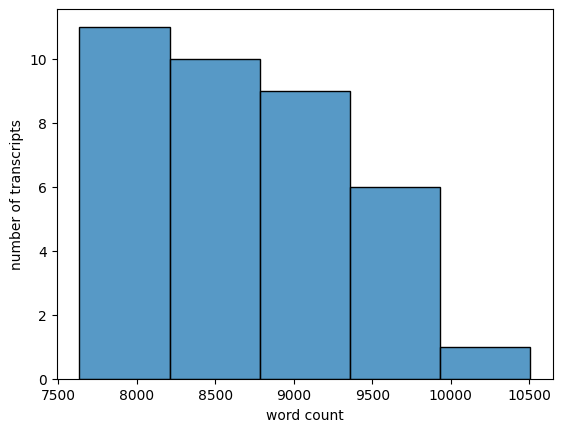

In [ ]:
import seaborn as sns
ax = sns.histplot(df['doc'].apply(lambda x: len(x.split())), bins=5)
ax.set_xlabel('word count'); ax.set_ylabel('number of transcripts');

And we can take a look at the content:

(For the full transcript in pdf format, see the investor relations page for Alphabet: [2024-q2-earnings-transcript.pdf](https://abc.xyz/assets/bd/7b/d57831684953be8bcc2c5a42aee8/2024-q2-earnings-transcript.pdf))

In [ ]:
print(df.doc.iloc[0][:2000])

Operator: Welcome, everyone. Thank you for standing by for the Alphabet Fourth Quarter 2023 Earnings Conference Call. [Operator Instructions] 
 I would now like to hand the conference over to your speaker today, Jim Friedland, Director of Investor Relations. Please go ahead. 
James Friedland: Thank you. Good afternoon, everyone, and welcome to Alphabet's Fourth Quarter 2023 Earnings Conference Call. With us today are Sundar Pichai, Philipp Schindler and Ruth Porat. 
 Now I'll quickly cover the safe harbor. Some of the statements that we make today regarding our business, operations and financial performance may be considered forward-looking. Such statements are based on current expectations and assumptions that are subject to a number of risks and uncertainties. Actual results could differ materially. Please refer to our Forms 10-K and 10-Q, including the risk factors discussed in our upcoming Form 10-K filing for the year ended December 31, 2023. We undertake no obligation to update a

# 2. Create an index and upload data



The basic unit for Sturdy Statistics workflows is the _index_.
An index stores your data, indexes it for search, and allows you to query your data using SQL.
An index also allows you to train our machine learning models for more sophisticated analysis.

Indexes are private to your API key, and each index associated with your API key has a unique _name_ and a unique identifier known as the _index_id_.
For this demo, we&rsquo;ll go ahead and make a new index with the name `demo_tech_earnings_calls_v1`:

In [ ]:
index = Index(API_key=API_KEY, name="demo_tech_earnings_calls_v1")
index.get_status()

Found an existing index with id="index_05a7cb07da764f0f81397b39ce65ab06".


{'index_id': 'index_05a7cb07da764f0f81397b39ce65ab06',
 'name': 'demo_tech_earnings_calls__v1',
 'state': 'ready'}

We can see that Sturdy Statistics has automatically assigned us an `index_id`.
If we want to access this index later, we can look it up by name, or we can retrieve it directly by the `index_id`.

We can also see that this index has a state `'untrained'`.
Not for long!

## Upload the data

The upload accepts a list of dictionaries (JSON records format).
Our only requirement is a plain-text field named `doc` which contains the text you want to analyze.
You can optionally provide a `doc_id` identifier for each document; if you do not provide one, we will generate one for you.

If you specify a `doc_id` which already exists, you can append metadata to the document (by leaving the `doc` field blank), or overwrite the `doc` content for that document (by placing new content in the `doc` field.)

The next two examples demonstrate the JSON records format:

In [ ]:
from rich.pretty import pprint
pprint(df.iloc[:2].to_dict(orient='records'), max_string=80, indent_guides=False)

[
    {
        'ticker': 'GOOG',
        'quarter': '2024Q1',
        'year': 2023,
        'doc': 'Operator: Welcome, everyone. Thank you for standing by for the Alphabet Fourth Q'+50272,
        'published': '2024-01-30',
        'title': 'GOOG 2024Q1',
        'author': 'GOOG',
        'priceDelta': -0.09134566261367119
    },
    {
        'ticker': 'GOOG',
        'quarter': '2023Q4',
        'year': 2023,
        'doc': 'Operator: Welcome, everyone. Thank you for standing by for the Alphabet Third Qu'+46212,
        'published': '2023-10-24',
        'title': 'GOOG 2023Q4',
        'author': 'GOOG',
        'priceDelta': -0.08309488382740071
    }
]

And we can perform the upload as follows:

In [ ]:
res = index.upload(df.to_dict("records"))

Uploading data to UNTRAINED index for training.
uploading data to index...
committing changes to index "index_05a7cb07da764f0f81397b39ce65ab06"...

Note that the index status is now `'ready'`.
This means we can now query our data, or train a model.

Our main goal is to train a model, but we&rsquo;ll start with a few examples how to query an untrained index:

In [ ]:
index.get_status()

{'index_id': 'index_05a7cb07da764f0f81397b39ce65ab06',
 'name': 'demo_tech_earnings_calls__v1',
 'state': 'ready'}

## Query the data

We can immediately query any uploaded data via standard SQL.
This dataset does not contain very rich metadata; as a result, querying this data is not (yet) particularly interesting.

The following examples demonstrate how to handle discrete and real-valued metadata fields:

In [ ]:
index.queryMeta("SELECT quarter, count(*) as c FROM doc_meta GROUP BY quarter ORDER BY quarter" )

[{'quarter': '2022Q2', 'c': 1},
 {'quarter': '2022Q3', 'c': 1},
 {'quarter': '2022Q4', 'c': 2},
 {'quarter': '2023Q1', 'c': 3},
 {'quarter': '2023Q2', 'c': 5},
 {'quarter': '2023Q3', 'c': 5},
 {'quarter': '2023Q4', 'c': 5},
 {'quarter': '2024Q1', 'c': 5},
 {'quarter': '2024Q2', 'c': 4},
 {'quarter': '2024Q3', 'c': 4},
 {'quarter': '2024Q4', 'c': 2}]

In [ ]:
index.queryMeta("SELECT min(priceDelta), median(priceDelta), mean(priceDelta), max(priceDelta) FROM doc_meta")

[{'min(priceDelta)': -0.11673849042112898,
  'median(priceDelta)': 0.015287205521647368,
  'mean(priceDelta)': 0.020768983716843673,
  'max(priceDelta)': 0.212319790300389}]

In [ ]:
# who had the worst day?
#
index.queryMeta("""
SELECT ticker, quarter, priceDelta 
FROM doc_meta 
WHERE priceDelta = 
    (SELECT min(priceDelta) FROM doc_meta)
""")

[{'ticker': 'META', 'quarter': '2024Q2', 'priceDelta': -0.11673849042112898}]

In [ ]:
# who had the best day?
#
index.queryMeta("""
SELECT ticker, quarter, priceDelta 
FROM doc_meta 
WHERE priceDelta = 
    (SELECT max(priceDelta) FROM doc_meta)
""")

[{'ticker': 'NVDA', 'quarter': '2023Q2', 'priceDelta': 0.212319790300389}]

As we will see below, querying this dataset becomes extremely powerful once we train an AI model on this index.

The Sturdy Statistics AI model identifies recurring themes in the dataset, and indexes each document according to its thematic content.
This process actually _structures_ the otherwise unstructed data in the `doc` field, permitting you to analyze the document content using the same SQL tools that you would use for the structured metadata fields.

Our approach unifies the unstructured document content with the metadata, allowing you to perform powerful analyses.

# 3. Train an AI model

Training requires no parameters at all&hellip; if you wish, you can automatically structure your data with a simple `index.train()`.
However, our model can take advantage of more information about the data if you choose to provide it.
We will refine the training using two optional arguments: `regex_paragraph_splitter` and `doc_hierarchy`.

The simpler of the two is `regex_paragraph_splitter`: this argument allows the user to provide a regex string which splits each document into paragraphs.
When you do this, we will infer the thematic content of each paragraph as well as for the document as a whole.
This enables more fine-grained search and analysis: for example, if some document as a whole is not particularly relevant to your query, but it contains a single paragraph which is highly pertinent, this chunking will enable us to rank it more appropriately.
The earnings calls have been cleanly formatted, and paragraphs always begin on new lines, so we can simply specify `regex_paragraph_splitter="\n"`.
(Note that this must be set for your particular dataset; if the text were filled to a fixed width, we would instead use `"^\n\t"`, or if paragraphs followed empty lines, we would use `"\n\n"`.)

Though the parameter is called a &ldquo;paragraph&rdquo; splitter, you can choose any semantic unit that is appropriate for your analysis.
For earnings calls, as for most documents, we expect paragraphs to be the most helpful semantic unit.
However, if you&rsquo;re working with _very_ long documents which have section or chapter divisions, you might consider using those divisions instead.

TODO: The `doc_hierarchy` parameter is more subtle: you can check the documentation (LINK) or this notebook (LINK) which dives into it.

With all of that out of the way, we can go ahead and kick off training:

In [ ]:
doc_hierarchy = ["quarter", "ticker"]
regex_paragraph_splitter = "\n"
job = index.train(dict(doc_hierarchy=doc_hierarchy, regex_paragraph_splitter=regex_paragraph_splitter), wait=False)
job.get_status()

## Crunching the numbers
Because we set `wait=False`, the train function call returns immediately with a `job` object.
This object allows us to poll the training job and check its status.
Training time scales linearly with the number of tokens in your dataset; it can take anywhere from a few minutes to &sim;48 hours.

We are training a custom model tuned to your data and your data alone.
Our Bayesian deep learning algorithm hierarchically organizes your data and identifies the data&rsquo;s recurring themes.
The model then orgainizes these themes into a discrete set of topics, and tags each word, sentence, paragraph, document with its thematic content.

While you wait for your model to finish training, we can take a look at one we have already trained:

You can then analyze this thematic content however you wish, including comparing it with any structured metadata you provide.
By its very nature, this statistical structure does not hallucinate, and it readily permits quantitative analysis on unstructured data. 

Once a model is trained, all future uploads will automatically be indexed using the same statistical structure.

In a follow-on notebook, we will dive deeper into the sorts of analysis you can do with this thematic data.

While you wait, you can explore a model that has already been trained on this dataset here: https://sturdystatistics.com/analyze?folder_id=index_05a7cb07da764f0f81397b39ce65ab06&comp_fields=ticker,quarter&max_excerpts_per_doc=5&bar_plot_fields=ticker,quarter


# 4. Explore your data!

Once the job is done, you can explore your data using our website&rsquo;s dashboard!

If you wish, you can also use SQL expressions to build out your own visualizations; we will demonstrate this in a separate notebook.

In [ ]:
def getURL(index_id, api_key):
    url = f"https://sturdystatistics.com/analyze?folder_id={index_id}&comp_fields=ticker,quarter&max_excerpts_per_doc=5&bar_plot_fields=ticker,quarter"
    if api_key is not None:
        url += f"&api_key={api_key}"
    return url
print("index_id:", index.id)
getURL(index.id, API_KEY)
job.wait()

index_id: index_05a7cb07da764f0f81397b39ce65ab06


'https://sturdystatistics.com/analyze?folder_id=index_05a7cb07da764f0f81397b39ce65ab06&comp_fields=ticker,quarter&max_excerpts_per_doc=5&bar_plot_fields=ticker,quarter'

# 5. Next Steps

We have a series of additional notebooks in this series
1. Upload the data
2. Build Visualizations
3. Throw our dirty old RAGs: Use Topic Augmented Generation to supercharge LLMs. 